/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Jaccard Coefficient =  0.2018642586658899
Rand Index =  0.45669294284463635


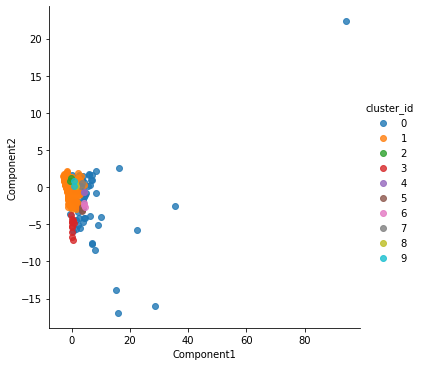

In [31]:
#DBSCAN implementation

#dbscan latest submission

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
import pandas as pd

#initializing the values for Epsilon and Minimum points
epsilon = 1.45                                                                                        #epsilon value to be changed
minimum_points = 2                                                                                    #minimum points to be changed

# load dataset from the specified path
dt = pd.read_csv("/content/iyer.txt",delimiter="\t",header=None)                                    #file name to be changed
genes = dt.iloc[:, :]  #importing the entire dataset
gene_data = []


# preprocessing and converting the dataset to a list of list by removing the first column and label column
for i in range(0,len(genes)):
  temp = []
  for j in range(0,len(genes.columns)):
    genes[j][i] = str(genes[j][i])
    temp.append(genes[j][i])
  gene_data.append(temp)
data=np.asarray(gene_data)
label = data[:,1]
data= np.matrix(data[:,2:],dtype=float,copy=False)

#initializing the lists for storing the cluster Id of all the points  and visiting the point
cluster_final =np.zeros(len(data),dtype=int)
visited=np.zeros(len(data),dtype=bool)

#computes and stores the disstance between each point from the dataser as a matrix p = 2 denotes metrice as eucledian
distancematrix=distance_matrix(data,data, p =2)
# distancematrix = distance.pdist(data, metric='euclidean')

#Finding the neighbor points for a particular data point
def regionQuery(query_point_index,points,epsilon,distancematrix):
    neighbour_list = []
    for i in range(len(points)):
        if distancematrix[query_point_index][i] <= epsilon:
            neighbour_list.append(i)
    return neighbour_list

#computes the neighbor points of the core points and expands tehe cluster
def expandCluster(corepoint_index,points, neighbour_pts,cluster,epsilon, minimum_points,cluster_final,visited,distancematrix):
     i=0
     while i < len(neighbour_pts):
         if (not visited[neighbour_pts[i]]):
             visited[neighbour_pts[i]]=True
             new_neighbours = regionQuery(neighbour_pts[i],points,epsilon,distancematrix)
             if (len(new_neighbours) >= minimum_points):
                 neighbour_pts=neighbour_pts+new_neighbours
             if (cluster_final[neighbour_pts[i]]==0):
                 cluster_final[neighbour_pts[i]]=cluster;
         i=i+1

#reads each unvisited point from data and returns the final cluster allocation of each point 
def dbscan(points,epsilon,min_points,visited,cluster_final,distancematrix):
    cluster= 0
    for i in range(len(points)):
        if (not visited[i]):
            visited[i]=True
            neighbour_pts = regionQuery(i,points,epsilon,distancematrix)
            if (len(neighbour_pts)<min_points):
                cluster_final[i]=0
            else:
                cluster=cluster+1;
                cluster_final[i]=cluster;
                expandCluster(i,points, neighbour_pts,cluster,epsilon, min_points,cluster_final,visited,distancematrix)

#performs PCA dimensionality reduction on the data when the number of attributes is greater than 2 and plots the scatter plot
def PCA_DimensionalityReduction(data,weights):
  pca_output = PCA(n_components=2).fit_transform(data)
  pca_output =np.asarray(pca_output)
  weights = np.asarray(weights)
  pca_output_df = pd.DataFrame(pca_output, columns=['Component1','Component2'], index=label)
  weights_df = pd.DataFrame(weights)
  pca_output_df['cluster_id'] = weights
  #plotting using seaborn
  lm = sns.lmplot(x='Component1', y='Component2', data=pca_output_df, fit_reg=False, hue='cluster_id')
  plt.show()

#Plots the scatter plot when the number of attributes is less than 2 
def visualization(data,weights):
  data_output =np.asarray(data)
  weights = np.asarray(weights)
  pca_output_df = pd.DataFrame(data_output, columns=['Column1','Column2'], index=label)
  weights_df = pd.DataFrame(weights)
  pca_output_df['cluster_id'] = weights
  #plotting using seaborn
  lm = sns.lmplot(x='Column1', y='Column2', data=pca_output_df, fit_reg=False, hue='cluster_id')
  plt.show()

#function for evaluating the algorith by computing the Jaccard and Rand index 
def jaccard_and_rand(data,label,cluster_final):
  data_array = np.asarray(data, dtype = float)
  # gene_id = data_array[:,0]
  # ground_truth = data_array[:,1]
  # attributes = np.delete(data_array,np.s_[0:2],axis = 1)
  true_positive = 0
  true_negative = 0
  false_positive=0
  false_negative=0
  for i in range(len(data_array)):
    for j in range(len(data_array)):
      if label[i]==label[j]:
        if cluster_final[i]==cluster_final[j]:
          true_positive=true_positive+1
        else:
          false_negative=false_negative+1
      elif label[i]!=label[j]:
        if cluster_final[i]==cluster_final[j]:
          false_positive=false_positive+1
        else:
          true_negative=true_negative+1
  jaccard=(true_positive)/(true_positive+false_positive+false_negative)
  rand=(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
  return jaccard,rand     



#calling the main dbscan function
dbscan(data,epsilon,minimum_points,visited,cluster_final,distancematrix)
#calling the jccard and rand index evaluations
jaccard_value,rand_index_value=jaccard_and_rand(data,label,cluster_final)
print("Jaccard Coefficient = ",jaccard_value)
print("Rand Index = ",rand_index_value)

#calling PCA and visualization based on the dimensionality of the dataset
num_cols = np.shape(data)[1]
if num_cols > 2:
  PCA_DimensionalityReduction(data,cluster_final)
else:
  visualization(data, cluster_final)
# print(cluster_final)
